In [3]:
import numpy as np
import pickle
from pandas import DataFrame, read_csv
from sklearn import preprocessing
from sklearn import metrics as met
import warnings
import tensorflow as tf
from tensorflow.contrib import rnn
import helperModule as hm
import matplotlib.pyplot as plt
from tensorflow import nn
from matplotlib import gridspec

warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'



In [29]:
#########################
############ Hyperparamter
#########################

st_dev = 0.2
learning_rate = 0.005
training_iters = 22000000
batch_size = 128
display_step = 100
display_testing_step = 400
dropout_rate = 0.97

n_input = 41 # Number of features
n_steps = 1 # timesteps
n_hidden = 96 # hidden layer num of nodes
n_classes = 5 # KDD99 total classes ( Normal + 4 attack types)


In [5]:
#########################
############ Read in data
#########################

data = pickle.load( open( "kdd99.p", "rb" ) )

x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']


In [30]:
tf.reset_default_graph()

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# Define weights
W = {
    'out': tf.Variable(tf.truncated_normal([n_hidden, n_classes], stddev=st_dev))
}

b = {
    'out': tf.Variable(tf.zeros([n_classes]))
}

In [31]:
num_layers = 2

def RNN(x, W, b):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, n_steps, 1)
 
    stacked_rnn = []
    for i in range(num_layers):
        stacked_rnn.append(tf.nn.rnn_cell.LSTMCell(n_hidden, state_is_tuple=True))
    

    lstm_cell = tf.contrib.rnn.MultiRNNCell(stacked_rnn)                
        
    output, states = tf.nn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(output[-1], W['out']) + b['out']



In [32]:

pred = RNN(x, W, b)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


In [33]:
# Initializing the variables
init = tf.global_variables_initializer()


In [34]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    losses = {'train':[], 'validation':[]}
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        offset_val = (step * batch_size) % (y_test.shape[0] - batch_size)
        
        # Generate minibatches for training and validating.
        batch_x = x_train[offset:(offset + batch_size), :]
        batch_y = y_train[offset:(offset + batch_size), :]
        batch_val_x = x_test[offset_val:(offset_val + batch_size), :]
        batch_val_y = y_test[offset_val:(offset_val + batch_size), :]
        
        # Reshape data to feed into RNN
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        batch_val_x = batch_val_x.reshape((batch_size, n_steps, n_input))
        
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
        loss_test = sess.run(cost, feed_dict={x: batch_val_x, y: batch_val_y})

        if step % display_step == 0:

            print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + "{:.6f}".format(loss) +  ", Minibatch Val Loss= " + \
                  "{:.6f}".format(loss_test)
                        
        losses['train'].append(loss)
        losses['validation'].append(loss_test)
        step += 1
            
    print("Optimization Finished!")

    y_pred = sess.run(tf.argmax(pred, 1), feed_dict={x:x_test.reshape((-1, n_steps, n_input)), keep_prob:1.0})
    y_true = np.argmax(y_test,1)
    conf_matrix = met.confusion_matrix(y_true, y_pred)
    
    

Iter 12800, Minibatch Loss= 1.524155, Minibatch Val Loss= 0.168554
Iter 25600, Minibatch Loss= 0.015906, Minibatch Val Loss= 1.384297
Iter 38400, Minibatch Loss= 0.001586, Minibatch Val Loss= 0.658240
Iter 51200, Minibatch Loss= 0.286967, Minibatch Val Loss= 0.002990
Iter 64000, Minibatch Loss= 0.002118, Minibatch Val Loss= 0.292712
Iter 76800, Minibatch Loss= 0.436575, Minibatch Val Loss= 0.551765
Iter 89600, Minibatch Loss= 0.035121, Minibatch Val Loss= 1.741717
Iter 102400, Minibatch Loss= 0.001552, Minibatch Val Loss= 1.865470
Iter 115200, Minibatch Loss= 0.000802, Minibatch Val Loss= 2.929638
Iter 128000, Minibatch Loss= 0.000436, Minibatch Val Loss= 5.904868
Iter 140800, Minibatch Loss= 0.790340, Minibatch Val Loss= 4.619667
Iter 153600, Minibatch Loss= 0.001950, Minibatch Val Loss= 0.158586
Iter 166400, Minibatch Loss= 0.000544, Minibatch Val Loss= 8.054159
Iter 179200, Minibatch Loss= 0.000322, Minibatch Val Loss= 0.319354
Iter 192000, Minibatch Loss= 0.000201, Minibatch Val Lo

Iter 1548800, Minibatch Loss= 0.000001, Minibatch Val Loss= 0.000002
Iter 1561600, Minibatch Loss= 0.004967, Minibatch Val Loss= 0.000003
Iter 1574400, Minibatch Loss= 0.087919, Minibatch Val Loss= 0.000001
Iter 1587200, Minibatch Loss= 0.002272, Minibatch Val Loss= 0.003500
Iter 1600000, Minibatch Loss= 0.000004, Minibatch Val Loss= 1.678918
Iter 1612800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 1625600, Minibatch Loss= 0.159450, Minibatch Val Loss= 0.000000
Iter 1638400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000010
Iter 1651200, Minibatch Loss= 0.000000, Minibatch Val Loss= 1.258954
Iter 1664000, Minibatch Loss= 0.000000, Minibatch Val Loss= 7.808689
Iter 1676800, Minibatch Loss= 0.000000, Minibatch Val Loss= 7.897663
Iter 1689600, Minibatch Loss= 0.000000, Minibatch Val Loss= 1.594636
Iter 1702400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.023308
Iter 1715200, Minibatch Loss= 0.000000, Minibatch Val Loss= 7.956712
Iter 1728000, Minibatch Loss= 0.00

Iter 3072000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 3084800, Minibatch Loss= 0.000000, Minibatch Val Loss= 1.307781
Iter 3097600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 3110400, Minibatch Loss= 0.134410, Minibatch Val Loss= 0.000000
Iter 3123200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 3136000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 3148800, Minibatch Loss= 0.000000, Minibatch Val Loss= 1.108557
Iter 3161600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 3174400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 3187200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.317532
Iter 3200000, Minibatch Loss= 0.000000, Minibatch Val Loss= 1.092720
Iter 3212800, Minibatch Loss= 0.000000, Minibatch Val Loss= 2.146928
Iter 3225600, Minibatch Loss= 0.000000, Minibatch Val Loss= 2.146819
Iter 3238400, Minibatch Loss= 0.000000, Minibatch Val Loss= 6.757547
Iter 3251200, Minibatch Loss= 0.00

Iter 4595200, Minibatch Loss= 0.016757, Minibatch Val Loss= 0.000002
Iter 4608000, Minibatch Loss= 0.000002, Minibatch Val Loss= 0.000002
Iter 4620800, Minibatch Loss= 0.000001, Minibatch Val Loss= 0.000001
Iter 4633600, Minibatch Loss= 0.000001, Minibatch Val Loss= 0.000001
Iter 4646400, Minibatch Loss= 0.000001, Minibatch Val Loss= 0.000000
Iter 4659200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 4672000, Minibatch Loss= 0.000000, Minibatch Val Loss= 1.324936
Iter 4684800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 4697600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 4710400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 4723200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 4736000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 4748800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000277
Iter 4761600, Minibatch Loss= 0.000000, Minibatch Val Loss= 3.983728
Iter 4774400, Minibatch Loss= 0.00

Iter 6118400, Minibatch Loss= 0.000001, Minibatch Val Loss= 0.131511
Iter 6131200, Minibatch Loss= 0.000001, Minibatch Val Loss= 0.000002
Iter 6144000, Minibatch Loss= 0.000001, Minibatch Val Loss= 0.000298
Iter 6156800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 6169600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 6182400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 6195200, Minibatch Loss= 0.000000, Minibatch Val Loss= 1.004130
Iter 6208000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 6220800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 6233600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 6246400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 6259200, Minibatch Loss= 0.000000, Minibatch Val Loss= 1.902094
Iter 6272000, Minibatch Loss= 0.002390, Minibatch Val Loss= 0.000000
Iter 6284800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 6297600, Minibatch Loss= 0.00

Iter 7641600, Minibatch Loss= 0.000001, Minibatch Val Loss= 0.002136
Iter 7654400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000755
Iter 7667200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000290
Iter 7680000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 7692800, Minibatch Loss= 0.000000, Minibatch Val Loss= 3.434035
Iter 7705600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 7718400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 7731200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 7744000, Minibatch Loss= 0.000000, Minibatch Val Loss= 4.393590
Iter 7756800, Minibatch Loss= 0.000505, Minibatch Val Loss= 0.000000
Iter 7769600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 7782400, Minibatch Loss= 0.000009, Minibatch Val Loss= 0.000007
Iter 7795200, Minibatch Loss= 0.000003, Minibatch Val Loss= 0.000006
Iter 7808000, Minibatch Loss= 0.000013, Minibatch Val Loss= 1.543070
Iter 7820800, Minibatch Loss= 0.00

Iter 9164800, Minibatch Loss= 0.000000, Minibatch Val Loss= 1.282796
Iter 9177600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000005
Iter 9190400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000035
Iter 9203200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000256
Iter 9216000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000227
Iter 9228800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000836
Iter 9241600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 9254400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 9267200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 9280000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 9292800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 9305600, Minibatch Loss= 0.000000, Minibatch Val Loss= 2.882246
Iter 9318400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 9331200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 9344000, Minibatch Loss= 0.01

Iter 10675200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000037
Iter 10688000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000101
Iter 10700800, Minibatch Loss= 0.000000, Minibatch Val Loss= 7.191594
Iter 10713600, Minibatch Loss= 0.000000, Minibatch Val Loss= 4.886917
Iter 10726400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.081849
Iter 10739200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000287
Iter 10752000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000031
Iter 10764800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000041
Iter 10777600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000046
Iter 10790400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 10803200, Minibatch Loss= 0.000000, Minibatch Val Loss= 4.871286
Iter 10816000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 10828800, Minibatch Loss= 0.000294, Minibatch Val Loss= 0.000000
Iter 10841600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 10854400, Minib

Iter 12185600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 12198400, Minibatch Loss= 0.002979, Minibatch Val Loss= 0.000000
Iter 12211200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 12224000, Minibatch Loss= 0.003193, Minibatch Val Loss= 2.163036
Iter 12236800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.002852
Iter 12249600, Minibatch Loss= 0.000000, Minibatch Val Loss= 1.714436
Iter 12262400, Minibatch Loss= 0.000000, Minibatch Val Loss= 3.262742
Iter 12275200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000386
Iter 12288000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000066
Iter 12300800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000061
Iter 12313600, Minibatch Loss= 0.000020, Minibatch Val Loss= 0.000220
Iter 12326400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000292
Iter 12339200, Minibatch Loss= 0.000299, Minibatch Val Loss= 1.589488
Iter 12352000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000273
Iter 12364800, Minib

Iter 13696000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 13708800, Minibatch Loss= 0.000003, Minibatch Val Loss= 0.000000
Iter 13721600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000090
Iter 13734400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 13747200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 13760000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000001
Iter 13772800, Minibatch Loss= 0.000000, Minibatch Val Loss= 1.753239
Iter 13785600, Minibatch Loss= 0.000186, Minibatch Val Loss= 0.000002
Iter 13798400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 13811200, Minibatch Loss= 0.000000, Minibatch Val Loss= 8.864553
Iter 13824000, Minibatch Loss= 0.000000, Minibatch Val Loss= 6.941721
Iter 13836800, Minibatch Loss= 0.006358, Minibatch Val Loss= 0.014013
Iter 13849600, Minibatch Loss= 0.000020, Minibatch Val Loss= 0.000000
Iter 13862400, Minibatch Loss= 0.000003, Minibatch Val Loss= 0.002842
Iter 13875200, Minib

Iter 15206400, Minibatch Loss= 0.000000, Minibatch Val Loss= 3.713946
Iter 15219200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 15232000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 15244800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 15257600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 15270400, Minibatch Loss= 0.000719, Minibatch Val Loss= 1.313275
Iter 15283200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 15296000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 15308800, Minibatch Loss= 0.000067, Minibatch Val Loss= 0.129954
Iter 15321600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000002
Iter 15334400, Minibatch Loss= 0.000005, Minibatch Val Loss= 1.889471
Iter 15347200, Minibatch Loss= 0.000009, Minibatch Val Loss= 0.000000
Iter 15360000, Minibatch Loss= 0.000000, Minibatch Val Loss= 5.783048
Iter 15372800, Minibatch Loss= 0.000000, Minibatch Val Loss= 5.663347
Iter 15385600, Minib

Iter 16704000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000713
Iter 16716800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 16729600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 16742400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 16755200, Minibatch Loss= 0.000013, Minibatch Val Loss= 0.000000
Iter 16768000, Minibatch Loss= 0.000000, Minibatch Val Loss= 1.417365
Iter 16780800, Minibatch Loss= 0.000065, Minibatch Val Loss= 0.000005
Iter 16793600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 16806400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 16819200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 16832000, Minibatch Loss= 0.433398, Minibatch Val Loss= 0.000000
Iter 16844800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 16857600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 16870400, Minibatch Loss= 0.000183, Minibatch Val Loss= 3.227001
Iter 16883200, Minib

Iter 18214400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 18227200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 18240000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 18252800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 18265600, Minibatch Loss= 0.000000, Minibatch Val Loss= 5.770028
Iter 18278400, Minibatch Loss= 0.000914, Minibatch Val Loss= 0.000000
Iter 18291200, Minibatch Loss= 0.000004, Minibatch Val Loss= 0.000000
Iter 18304000, Minibatch Loss= 0.000006, Minibatch Val Loss= 0.000000
Iter 18316800, Minibatch Loss= 0.000680, Minibatch Val Loss= 0.001362
Iter 18329600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 18342400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.962071
Iter 18355200, Minibatch Loss= 0.000414, Minibatch Val Loss= 0.000000
Iter 18368000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 18380800, Minibatch Loss= 0.000084, Minibatch Val Loss= 0.310589
Iter 18393600, Minib

Iter 19724800, Minibatch Loss= 0.000000, Minibatch Val Loss= 8.922065
Iter 19737600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000032
Iter 19750400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 19763200, Minibatch Loss= 0.000014, Minibatch Val Loss= 0.000000
Iter 19776000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000108
Iter 19788800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.005557
Iter 19801600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.037358
Iter 19814400, Minibatch Loss= 0.000000, Minibatch Val Loss= 6.624241
Iter 19827200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000010
Iter 19840000, Minibatch Loss= 0.000033, Minibatch Val Loss= 0.000067
Iter 19852800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 19865600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 19878400, Minibatch Loss= 0.000000, Minibatch Val Loss= 3.691973
Iter 19891200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 19904000, Minib

Iter 21235200, Minibatch Loss= 0.000026, Minibatch Val Loss= 2.504737
Iter 21248000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.005509
Iter 21260800, Minibatch Loss= 0.000006, Minibatch Val Loss= 0.000000
Iter 21273600, Minibatch Loss= 0.000038, Minibatch Val Loss= 12.626933
Iter 21286400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.042881
Iter 21299200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 21312000, Minibatch Loss= 0.024584, Minibatch Val Loss= 0.000000
Iter 21324800, Minibatch Loss= 0.000103, Minibatch Val Loss= 0.081861
Iter 21337600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000004
Iter 21350400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.068136
Iter 21363200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 21376000, Minibatch Loss= 0.000113, Minibatch Val Loss= 0.000000
Iter 21388800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 21401600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 21414400, Mini

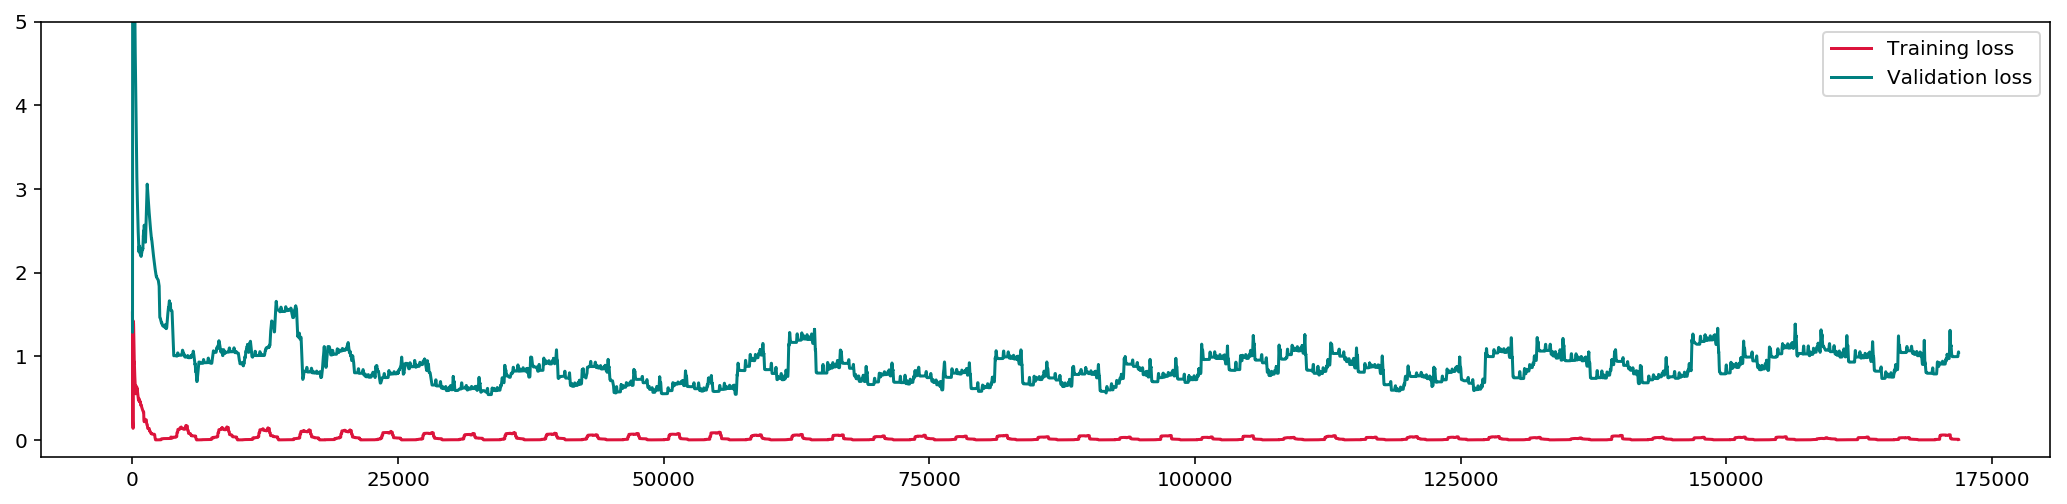

In [35]:

smoothed_loss = hm.running_mean(losses['train'], 1000)
smoothed_loss_train = hm.running_mean(losses['validation'], 2500)

fig = plt.figure(figsize=(18,4))
gs  = gridspec.GridSpec(1, 2, height_ratios=[1],width_ratios=[0.5,0.5])
ax1 = plt.subplot(gs[0, 0:2])

ax1.plot(smoothed_loss, label='Training loss', color='crimson')
ax1.plot(smoothed_loss_train, label='Validation loss', color='teal')
ax1.legend()
plt.ylim([-0.2,5])
plt.show()

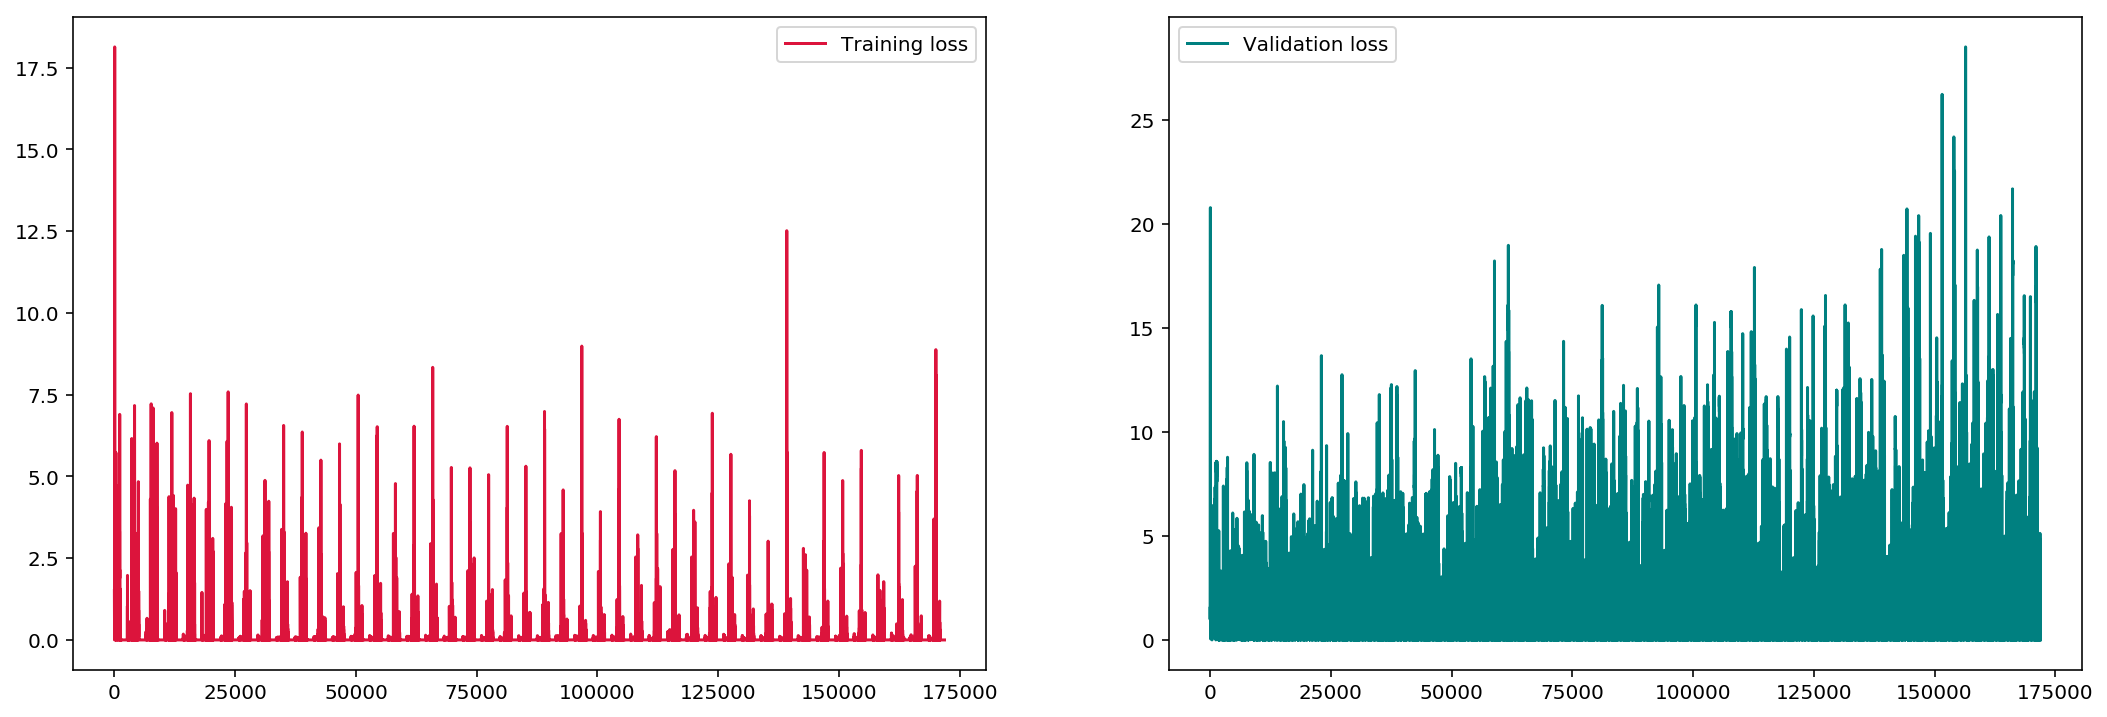

In [36]:
fig = plt.figure(figsize=(18,6))
gs  = gridspec.GridSpec(1, 2, height_ratios=[1],width_ratios=[0.5,0.5])
ax1 = plt.subplot(gs[0, 0:1])
ax2 = plt.subplot(gs[0, 1:])

ax1.plot(losses['train'], label='Training loss', color='crimson')
ax2.plot(losses['validation'], label='Validation loss', color='teal')
ax1.legend()
ax2.legend()

plt.show()

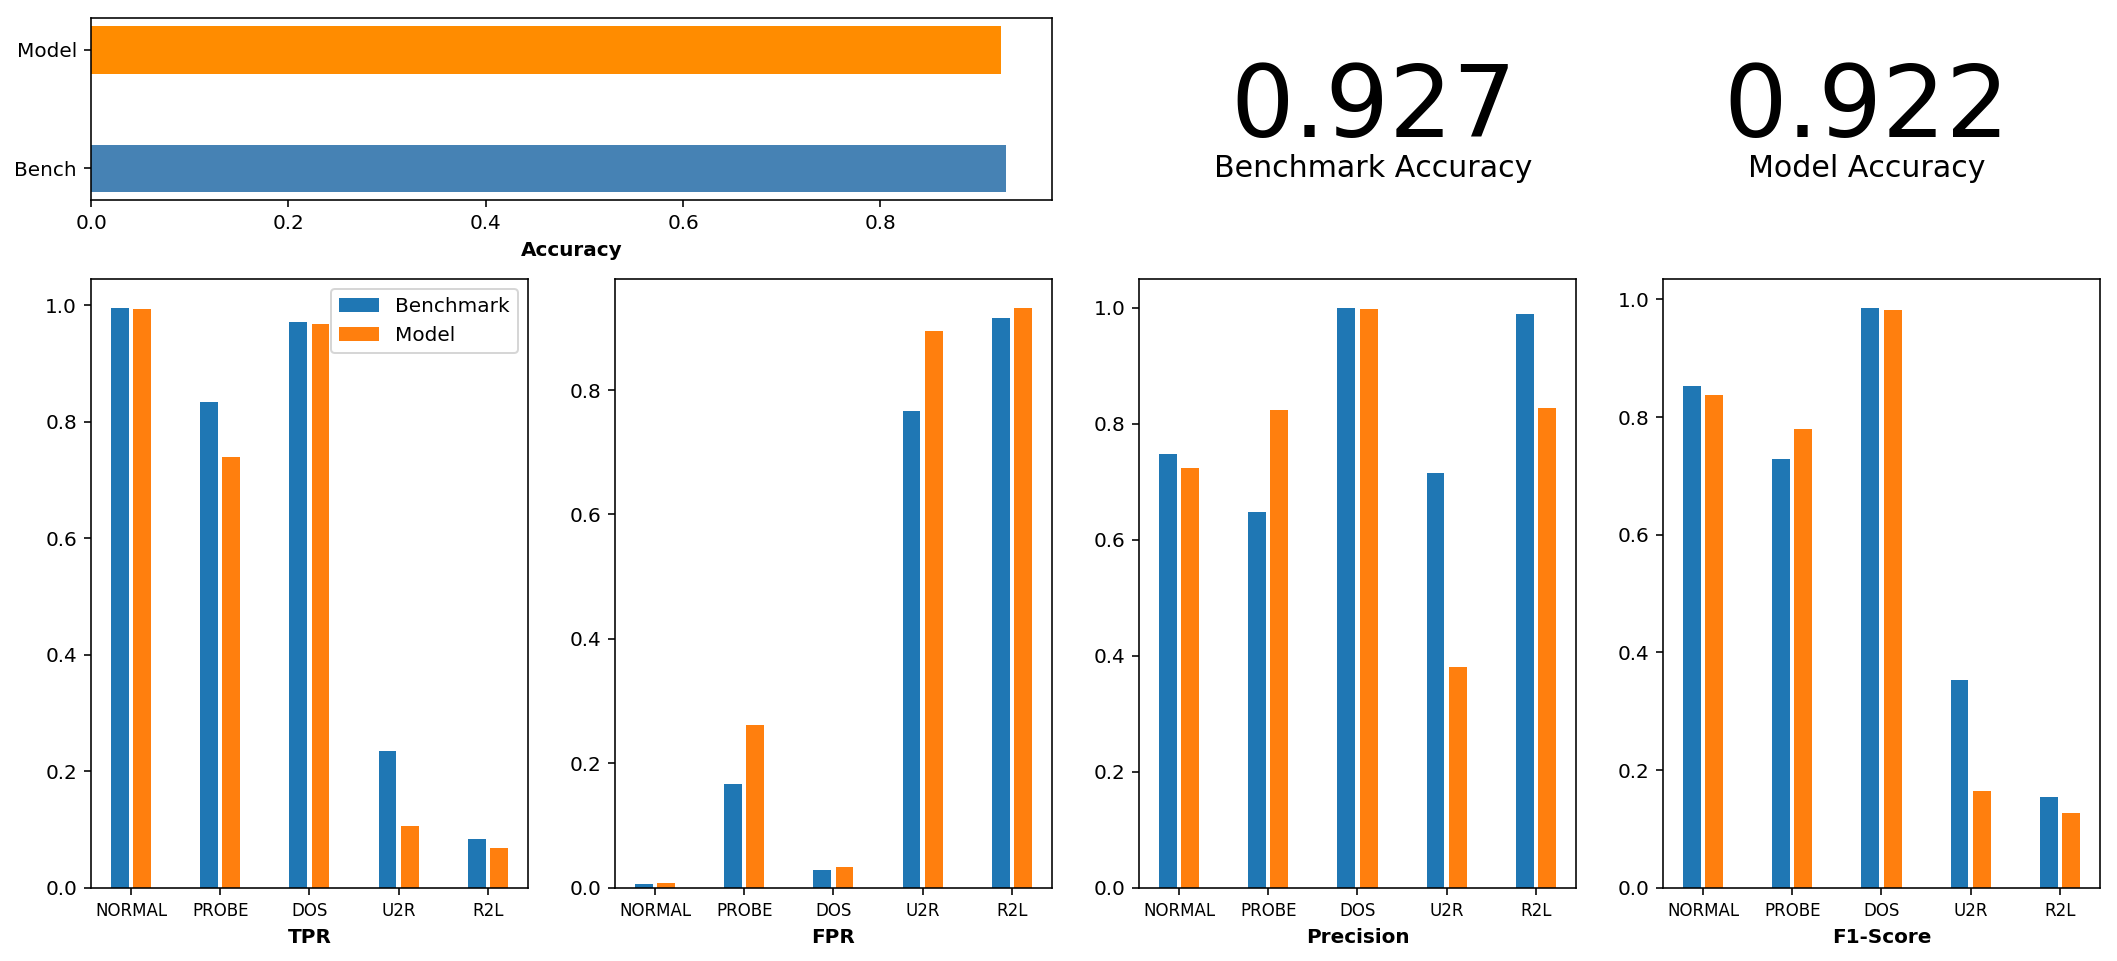

In [37]:
conf_bench = hm.getBenchmarkResults()
metrics = hm.computePerformanceMetrics(conf_bench, conf_matrix)
hm.plotMetrics(metrics)

